# Generatvie Adverserial Network

**Generative Adversarial Network is deep learning model that learns to generate new data (like images, audio, or text) that looks realistic. In this project I'm using a gan data of paintings and create a model that generates new painting similar to the data it was trained on.**

### Task 1: Load the dataset.

In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shubhamvigoniya","key":"bbc9bd13a11cfe5e77b3d5cfdb99ef3f"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle competitions download -c gan-getting-started


 92% 339M/367M [00:00<00:00, 384MB/s]
100% 367M/367M [00:00<00:00, 408MB/s]


In [5]:
!unzip gan-getting-started.zip -d gan_data


Streaming output truncated to the last 5000 lines.
  inflating: gan_data/photo_jpg/46e84039a1.jpg  
  inflating: gan_data/photo_jpg/46f391abec.jpg  
  inflating: gan_data/photo_jpg/46f5ef1042.jpg  
  inflating: gan_data/photo_jpg/4706619607.jpg  
  inflating: gan_data/photo_jpg/4707b03a08.jpg  
  inflating: gan_data/photo_jpg/47100a9939.jpg  
  inflating: gan_data/photo_jpg/471f4755b9.jpg  
  inflating: gan_data/photo_jpg/472b351bc4.jpg  
  inflating: gan_data/photo_jpg/472d5ac100.jpg  
  inflating: gan_data/photo_jpg/4758e5dd4c.jpg  
  inflating: gan_data/photo_jpg/4762bb79ef.jpg  
  inflating: gan_data/photo_jpg/4778b13518.jpg  
  inflating: gan_data/photo_jpg/4787b82d37.jpg  
  inflating: gan_data/photo_jpg/478e07feaa.jpg  
  inflating: gan_data/photo_jpg/478eb12a82.jpg  
  inflating: gan_data/photo_jpg/479698b371.jpg  
  inflating: gan_data/photo_jpg/4796d67f61.jpg  
  inflating: gan_data/photo_jpg/47aad493bd.jpg  
  inflating: gan_data/photo_jpg/47ae0edd23.jpg  
  inflating: gan_d

### **Task 2: Import necessary modules.**




In [15]:
import os

data_dir = "gan_data"
print(os.listdir(data_dir))



['photo_jpg', 'monet_tfrec', 'photo_tfrec', 'monet_jpg']


In [25]:
# STEP 1: Import Libraries
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import glob
import os

# STEP 2: Prepare Dataset (replace with your folder)
IMG_SIZE = 64
BATCH_SIZE = 64
data_path = "/content/gan_data/monet_jpg"  # folder with .jpg or .png images

def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = (img - 127.5) / 127.5
    return img

files = glob.glob(os.path.join(data_path, "*.jpg"))
dataset = tf.data.Dataset.from_tensor_slices(files).map(load_image).shuffle(1000).batch(BATCH_SIZE)
print("Total painting images:", len(files))


Total painting images: 300


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


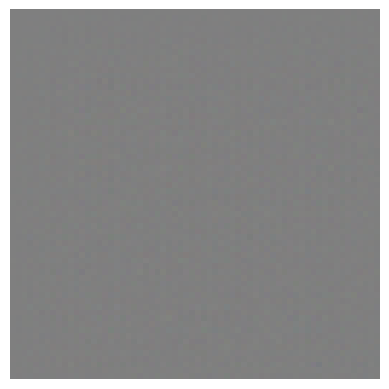

In [26]:
def make_generator():
    model = tf.keras.Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8,8,256)),

        layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = make_generator()
noise = tf.random.normal([1, 100])
plt.imshow((generator(noise, training=False)[0] + 1) / 2)
plt.axis('off')
plt.show()


### **Task 3:** **Methods for the model generation.**



In [27]:
def make_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[IMG_SIZE,IMG_SIZE,3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = make_discriminator()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss


In [31]:
EPOCHS = 100
noise_dim = 100

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


### **Task 4: Painting Generation**

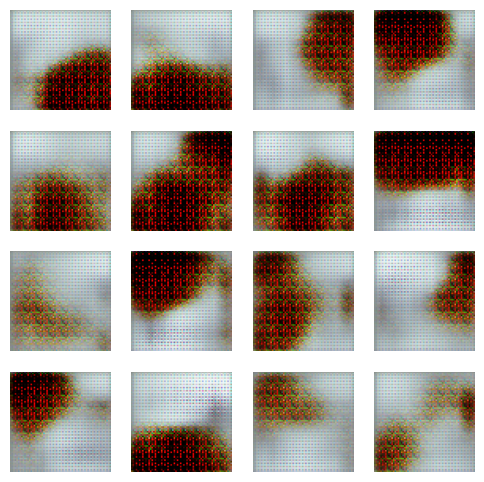

Epoch 100/100 finished in 12.47s


In [32]:
import time
from IPython.display import clear_output

for epoch in range(EPOCHS):
    start = time.time()
    for image_batch in dataset:
        train_step(image_batch)

    clear_output(wait=True)
    noise = tf.random.normal([16, noise_dim])
    generated = generator(noise, training=False)

    plt.figure(figsize=(6,6))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow((generated[i] + 1) / 2)
        plt.axis('off')
    plt.show()

    print(f"Epoch {epoch+1}/{EPOCHS} finished in {time.time()-start:.2f}s")
